In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import ipywidgets as widgets
import requests
import math as m
from tqdm.notebook import tqdm

from bond import Bond, ILB
from cpi import RefCPI
from datasets import df_prices, df_info

sns.set_theme(rc={'axes.facecolor': '#e3e3e3'})

## Exploratory Data Analysis
### Overview
Two datasets:
- Information on each bond: `df_info`
- Market data: `df_prices`:
    - `df_ilbs`
    - `df_noms`

In [2]:
ilbs = df_info[df_info["TYPE"] == "ILB"].index.values
noms = df_info[df_info["TYPE"]=="NOM"].index.values

df_ilbs = df_prices.loc[:,ilbs]
df_noms = df_prices.loc[:,noms]


df_info.head()

,ISIN CODE,NAME,COUPON,AMOUNT ISSUED,COUPON DATES,INDEX LINKED COUP,COUPONS PER YEAR,1ST COUPON VALUE,OTHER YIELD,RED. YIELD,CURRENCY,ISSUE DATE,MATURITY YEAR,START YEAR,ACTIVE,REDEMPTION DATE,REF CPI BASE,TYPE
Type,,,,,,,,,,,,,,,,,,
597973,CA135087UL60,CANADA 1991 4 1/4% 01/12/21 INDXLK.,7.3104,5175000.0,"01/06,01/12",4.25,2,2.026,-3.635,NaN,C$,1991-12-10 00:00:00,2021,1991,Dead,2021-12-01 00:00:00,83.07713,ILB
5771H1,CA13501ZCM91,CANADA 1993 PKG. STRIP 01/12/21 INDXLK.,0.0000,NaN,NaN,0.00,0,0.000,NaN,NaN,C$,1993-06-01 00:00:00,2021,1993,Dead,2021-12-01 00:00:00,NaN,ILB
491970,CA13506ZCL63,CANADA 1993 CPN. STRIP 01/12/21 INDXLK.,0.0000,NaN,NaN,0.00,0,0.000,NaN,NaN,C$,1993-09-02 00:00:00,2021,1993,Dead,2021-12-01 00:00:00,NaN,ILB
49197U,CA13506ZCG78,CANADA 1993 CPN. STRIP 01/12/19 INDXLK.,0.0000,NaN,NaN,0.00,0,0.000,NaN,NaN,C$,1993-09-02 00:00:00,2019,1993,Dead,2019-12-01 00:00:00,NaN,ILB
49197V,CA13506ZCH51,CANADA 1993 CPN. STRIP 01/06/20 INDXLK.,0.0000,NaN,NaN,0.00,0,0.000,NaN,NaN,C$,1993-09-02 00:00:00,2020,1993,Dead,2020-06-01 00:00:00,NaN,ILB


In [3]:
df_prices.tail()

,846111,610286,248402,97059Q,5653HV,787NK8,849UMH,645HW9,49199C,597973,...,650WAD,658V0W,651FLY,3925TN,5694XD,6561K8,8118P5,853J3Z,2360RY,615GG0
2023-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.121,82.630,99.988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.074,82.343,99.987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,62.604,82.173,99.987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.218,83.144,99.987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.664,83.545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Market Data Statistics

In [4]:
df_prices.describe()

,846111,610286,248402,97059Q,5653HV,787NK8,849UMH,645HW9,49199C,597973,...,650WAD,658V0W,651FLY,3925TN,5694XD,6561K8,8118P5,853J3Z,2360RY,615GG0
count,7101.000000,6388.000000,5291.000000,4254.000000,3472.000000,2560.000000,1644.000000,595.000000,5066.000000,3220.000000,...,588.000000,530.000000,581.000000,2802.000000,2838.000000,2831.000000,2832.000000,583.000000,583.000000,578.000000
mean,131.523548,140.659286,137.296017,125.957902,121.250779,118.027191,99.411933,83.899106,81.427279,123.895963,...,78.804447,89.147191,97.991910,107.067946,106.928226,105.448635,99.206059,99.478633,100.463827,99.733630
std,15.402941,17.718808,15.301789,14.941273,11.080769,11.938679,13.132456,14.599387,13.362473,12.519545,...,10.770882,4.844748,1.206898,4.853776,4.526640,3.318766,3.464770,0.315595,0.710531,0.291782
min,91.270000,97.190000,96.380000,83.407000,90.095000,85.543000,70.040000,62.547000,53.700000,100.012000,...,60.375000,81.216000,96.123000,97.540000,97.030000,97.820000,88.860000,98.993000,99.100000,99.135000
25%,121.046000,126.686250,125.490000,113.618750,114.745000,112.396500,91.504750,72.561500,71.290500,111.268000,...,71.195250,85.873000,96.837000,102.204250,102.967000,102.856000,96.997250,99.177500,99.959000,99.476250
50%,132.271000,145.215000,140.085000,130.043000,122.686500,118.104000,99.040500,77.984000,78.861500,127.878000,...,75.225000,87.921500,98.035000,108.149500,107.070500,104.674000,99.567000,99.465000,100.569000,99.867500
75%,143.390000,152.328000,148.416500,137.485000,129.272250,126.102250,109.214500,100.148000,95.691000,132.350000,...,89.779500,90.396000,99.042000,111.499500,111.249000,108.115000,101.971250,99.775000,101.121500,99.970000
max,163.310000,177.060000,167.760000,151.729000,144.881000,144.432000,126.483000,113.357000,99.632000,144.160000,...,101.304000,101.175000,100.109000,115.490000,115.449000,113.192000,105.464000,100.019000,101.453000,100.175000


## Historical Prices
### Inspecting the ILBs

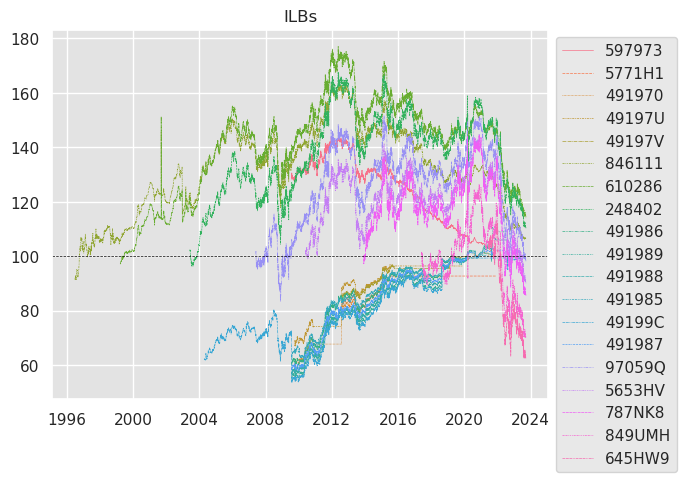

In [5]:
fig, ax = plt.subplots()
lines = sns.lineplot(df_ilbs,linewidth=0.5,ax=ax)
ax.axhline(y=100,linestyle="--",color="black",linewidth=0.5)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("ILBs")
plt.show()

### Maturities and reported Market Data
Compares the total runtime of the bond from issue date to redemption date with the covered market data:

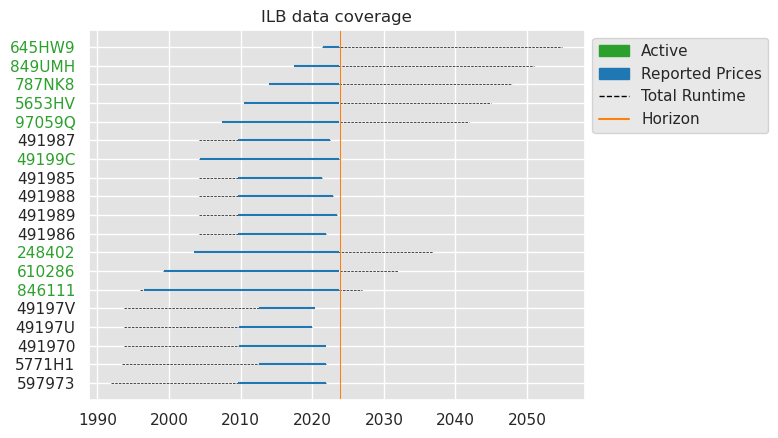

In [6]:
y = list(range(len(df_ilbs.columns)))
#available data
xmin = [min(df_ilbs[col].dropna().index) for col in df_ilbs.columns] 
xmax = [max(df_ilbs[col].dropna().index) for col in df_ilbs.columns]

#issue, maturity
issue_dates = [df_info.loc[bond,"ISSUE DATE"] for bond in df_ilbs.columns]
redem_dates = [df_info.loc[bond,"REDEMPTION DATE"] for bond in df_ilbs.columns]

fig, ax = plt.subplots()
plt.hlines(y=y,xmin=issue_dates,xmax=redem_dates, colors="black", linestyles="dashed", linewidths = .5)
plt.hlines(y=y,xmin=xmin,xmax=xmax,colors="tab:blue")
ax.axvline(x = max(df_ilbs.index),color="tab:orange",linewidth=0.75)
ax.set_yticks(list(range(len(df_ilbs.columns))))
ax.set_yticklabels(df_ilbs.columns)

for t in ax.yaxis.get_ticklabels():
    if df_info.loc[t.get_text(),"ACTIVE"] == "Active":
        t.set_color("tab:green")

plt.legend(handles=[mpatches.Patch(color="tab:green",label="Active"),
                    mpatches.Patch(color="tab:blue",label="Reported Prices"),
                    mlines.Line2D([0],[0],color="black",linestyle="dashed",linewidth=1, label="Total Runtime"),
                   mlines.Line2D([0],[1],color="tab:orange",label = "Horizon")])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("ILB data coverage")

plt.show()

### Inspecting Individual Time Series
Screening for outliers, general pattern etc.

In [7]:
#df_info.loc[ilbs,:]
#widgets.Dropdown(options=[(lbl,val) for lbl,val in zip(df_info.loc[ilbs,"NAME"].values,ilbs)])

In [8]:

#ilb_dropdown = widgets.Dropdown(description="ILB",options=list(map(lambda t:t[::-1],list(df_info.loc[ilbs,["NAME"]].itertuples(name=None)))))
ilb_dropdown = widgets.Dropdown(options=[(lbl,val) for lbl,val in zip(df_info.loc[ilbs,"NAME"].values,ilbs)],description="ILB")

def plot_hist_prices(bond):
    fig,ax = plt.subplots()
    sns.lineplot(df_ilbs,x=df_ilbs.index,y=bond,ax=ax,label=bond,linewidth=.75)
    ax.axhline(y=100,linestyle="--",color="black",linewidth=1)
    ax.set_ylabel("")
    ax.set_xlabel("")
    
    plt_out = widgets.Output()
    with plt_out:
        plt.show()
    tbl_out = widgets.Output()
    with tbl_out:
        display(df_info.loc[bond,:])

    display(widgets.HBox([plt_out,tbl_out]))

out_00 = widgets.interactive_output(plot_hist_prices,{"bond":ilb_dropdown})
display(ilb_dropdown,out_00)

Dropdown(description='ILB', options=(('CANADA 1991 4 1/4% 01/12/21 INDXLK.', '597973'), ('CANADA 1993 PKG. STR…

Output()

### Distribution of Prices
Inspecting the distribution of historical prices and relative location regarding the face value.

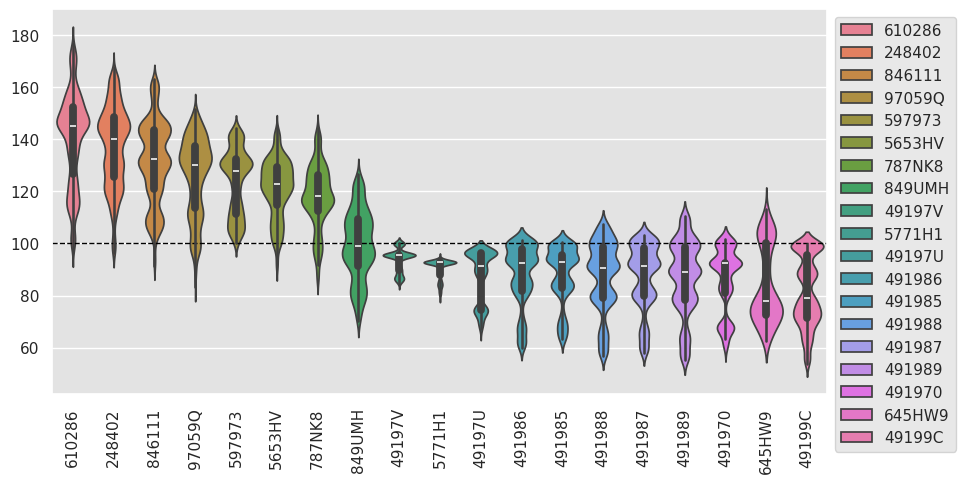

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=100,linestyle="--",color="black",linewidth=1)
sns.violinplot(df_ilbs.reindex(df_ilbs.mean().sort_values(ascending=False).index, axis=1),ax = ax,legend=True)
plt.xticks(rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

## Nominal (Reference) Bond Time Series Analysis

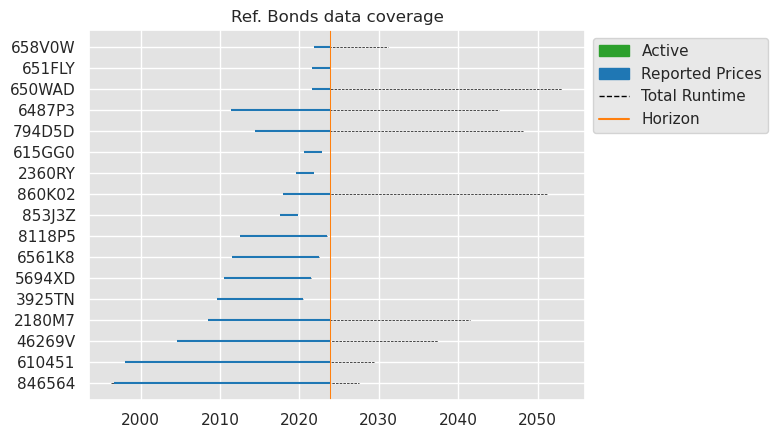

In [10]:
y = list(range(len(df_noms.columns)))
#available data
xmin = [min(df_noms[col].dropna().index) for col in df_noms.columns] 
xmax = [max(df_noms[col].dropna().index) for col in df_noms.columns]

#issue, maturity
issue_dates = [df_info.loc[bond,"ISSUE DATE"] for bond in df_noms.columns]
redem_dates = [df_info.loc[bond,"REDEMPTION DATE"] for bond in df_noms.columns]

fig, ax = plt.subplots()
plt.hlines(y=y,xmin=issue_dates,xmax=redem_dates, colors="black", linestyles="dashed", linewidths = .5)
plt.hlines(y=y,xmin=xmin,xmax=xmax,colors="tab:blue")
ax.axvline(x = max(df_noms.index),color="tab:orange",linewidth=0.75)
ax.set_yticks(list(range(len(df_noms.columns))))
ax.set_yticklabels(df_noms.columns)

for t in ax.yaxis.get_ticklabels():
    if df_info.loc[t.get_text(),"ACTIVE"] == "Active":
        t.set_color("tab:green")

plt.legend(handles=[mpatches.Patch(color="tab:green",label="Active"),
                    mpatches.Patch(color="tab:blue",label="Reported Prices"),
                    mlines.Line2D([0],[0],color="black",linestyle="dashed",linewidth=1, label="Total Runtime"),
                   mlines.Line2D([0],[1],color="tab:orange",label = "Horizon")])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Ref. Bonds data coverage")

plt.show()

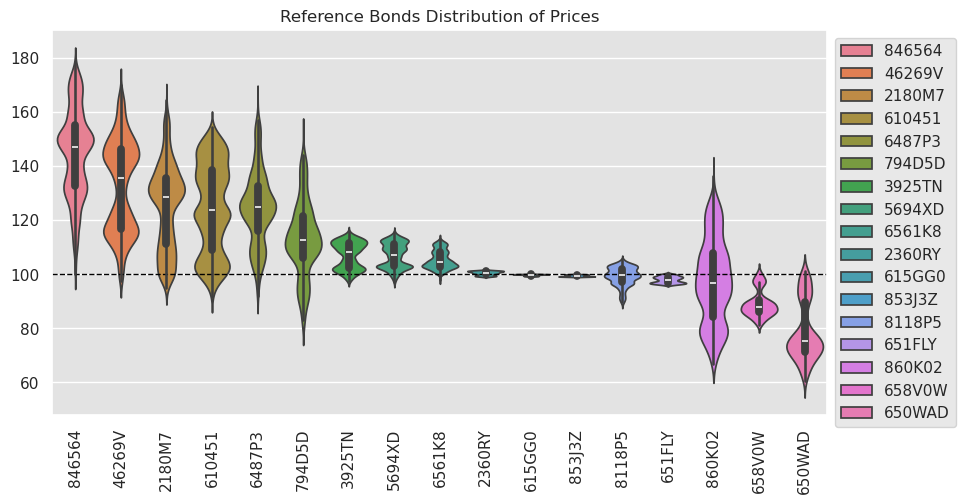

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=100,linestyle="--",color="black",linewidth=1)
sns.violinplot(df_noms.reindex(df_noms.mean().sort_values(ascending=False).index, axis=1),ax = ax,legend=True)
plt.xticks(rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Reference Bonds Distribution of Prices")
plt.show()

## ILBs vs. Refrence Bonds - Inspecting Historical Prices

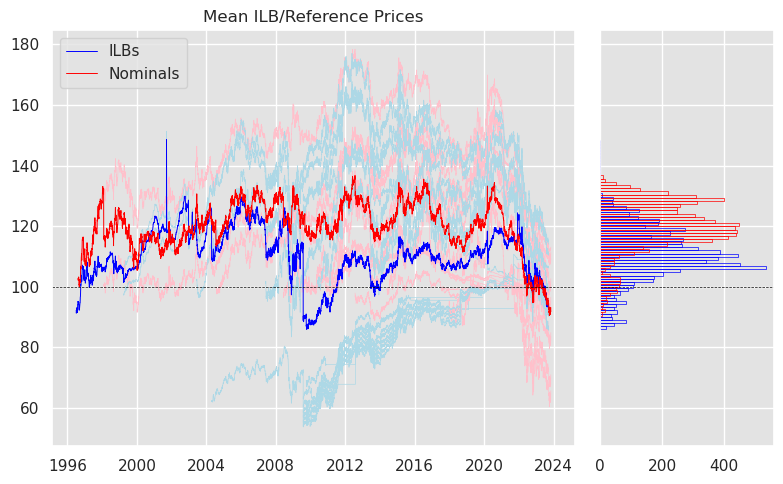

In [12]:
fig, axs = plt.subplots(ncols=2,width_ratios=(3,1),sharey=True,figsize=(8,5))

for ilb,ref in zip(df_ilbs.columns, df_noms.columns):
    sns.lineplot(x=df_ilbs.index,y=df_ilbs.loc[:,ilb],color="lightblue",ax=axs[0],linewidth=0.5)
    sns.lineplot(x=df_noms.index,y=df_noms.loc[:,ref],color="pink",ax=axs[0],linewidth=0.5)
    
ilb_means = df_ilbs.mean(axis=1)
nom_means = df_noms.mean(axis=1)

sns.lineplot(x=df_ilbs.index,y=ilb_means,color="blue",ax = axs[0], label="ILBs",linewidth=0.7)
sns.lineplot(x=df_noms.index,y=nom_means,color="red",ax = axs[0], label="Nominals",linewidth=0.7)

axs[0].axhline(y=100,linewidth=0.5,linestyle="--",color="black")
axs[0].set_title("Mean ILB/Reference Prices")
axs[0].set_ylabel("")

sns.histplot(y=ilb_means,color="blue",ax=axs[1],fill=False,kde=False)
sns.histplot(y=nom_means,color="red",ax=axs[1],fill=False,kde=False)
axs[1].axhline(y=100,linewidth=0.5,linestyle="--",color="black")

axs[0].set_xlabel("")
axs[1].set_xlabel("")

plt.tight_layout()
plt.show()

## Sub-sample Periods
Two or three subsample periods as identified by BoC - Empirical Analysis (...)
- January 1986 - December 1996: high and volatile inflation, large government financing needs
- January 1997 - May 2003: low and stable inflation
- (...)

[TODO]

In [13]:
#TODO

## Principal Components
There's many different possible drivers for the price of bonds among which is the interest rate. <br>
Following: A comparison of the hostoric prices of individual bonds and the observed interest rate in the bonds period.
### Interest Rates

In [14]:
df_interest = pd.read_csv("data/chartered_bank_interest.csv",index_col="date",parse_dates=True)
df_interest_info  =  pd.read_csv("data/chartered_bank_interest_info.csv",index_col = "id")
df_interest_info.replace(np.nan,"",inplace=True)
df_interest_info["description"] = df_interest_info["label"]+" "+df_interest_info["description"]
df_interest_info = df_interest_info.loc[:,["description"]]

fig, ax = plt.subplots()
df_interest.plot(ax = ax,linewidth=0.75)
plt.xticks(rotation=45)

out_01, out_02 = widgets.Output(), widgets.Output()

with out_01:
    plt.show()
with out_02:
    display(df_interest_info)

display(widgets.HBox([out_01,out_02]))

### Bond Market Prices vs. Interest Rates

In [15]:

interest_rate_dropdown = widgets.Dropdown(description="Interest",options=list(map(lambda t: t[::-1],df_interest_info[["description"]].itertuples(name=None))))

all_bonds = df_info.sort_values(by=["TYPE","ISSUE DATE"]).loc[:,"NAME"]
_options=[(lbl,val) for lbl,val in zip(all_bonds.values, all_bonds.index)]
bond_dropdown = widgets.Dropdown(options=_options,description="Bond")

def plot_price_vs_interest_rate(bond,rate,**kwargs):
    min_date,max_date = min(df_prices[bond].dropna().index), max(df_prices[bond].dropna().index)
    df_interest_temp = df_interest.loc[min_date:max_date,:]
    
    with sns.axes_style("dark"):
        fig,ax = plt.subplots()
        ax1 = plt.twinx()
        
    sns.lineplot(df_prices,x=df_prices.index,y=bond,ax=ax,linewidth=.75)
    ax.axhline(y=100,linestyle="--",color="black",linewidth=.5)
    
    sns.lineplot(df_interest_temp,x=df_interest_temp.index,y=rate,ax=ax1,color="tab:red",linewidth=0.75)

    ax.set_ylabel("Bond Price",color="tab:blue")
    ax1.set_ylabel("Interest Rate",color="tab:red")
    ax.set_xlabel("")
    ax1.set_xlabel("")

    plt_out,tbl_out = widgets.Output(), widgets.Output()
    with plt_out:
        plt.show()
    with tbl_out:
        display(df_info.loc[bond,:])
    display(widgets.HBox([plt_out,tbl_out]))


out_03 = widgets.interactive_output(plot_price_vs_interest_rate,{"bond":bond_dropdown,"rate":interest_rate_dropdown})
display(bond_dropdown,interest_rate_dropdown,out_03)

Dropdown(description='Bond', options=(('CANADA 1991 4 1/4% 01/12/21 INDXLK.', '597973'), ('CANADA 1993 PKG. ST…

Dropdown(description='Interest', options=(('Prime rate ', 'V80691311'), ('1-year Conventional mortgage', 'V806…

Output()

## Cashflow Structure and Nominal Coupon Payments 
Inspects the general cash flow structure that is used for calculating the YTMs:

## Simulation of Nominal vs. Real Cashflows
**Info**: Compares the nominal and real cashflows of matured ILBs (the calculation of the real cashflows requires knowledge about the realized inflation - this limits the possible ILBs to only those that are already matured).

In [16]:

def possible_dates(bond_id):
    return df_prices.loc[:,bond_id].dropna().index

def plot_cashflows(bond_id:str,eval_date:str,cp_only:bool,*args,**kwargs):
    issue_date = df_info.loc[bond_id,"ISSUE DATE"]
    redem_date = df_info.loc[bond_id,"REDEMPTION DATE"]
    coupon = df_info.loc[bond_id,"INDEX LINKED COUP"]
    coupon_freq = Bond.parse_coupon_dates(df_info.loc[bond_id,"COUPON DATES"])
    name = df_info.loc[bond_id,"NAME"]
    
    
    nominal_bond = Bond(issue_date,redem_date,coupon,coupon_freq=coupon_freq,id=bond_id,name=name)
    ilb_bond = ILB(issue_date,redem_date,coupon,coupon_freq=coupon_freq,id=bond_id,name=name)

    nominal_bond.prices = df_prices.loc[:,bond_id]
    ilb_bond.prices = df_prices.loc[:,bond_id]
    
    #eval_date = pd.Timestamp(eval_date)
    eval_price = nominal_bond.prices.loc[eval_date]

    nominal_bond.cashflows(eval_date,eval_price,dirty=False)
    ilb_bond.cashflows(eval_date,eval_price,dirty=False)
    
    nom_acc = Bond(issue_date,redem_date,coupon,coupon_freq=coupon_freq,id=bond_id,name=name)
    nom_acc.cashflows(eval_date,eval_price,dirty=True)

    real_acc = ILB(issue_date,redem_date,coupon,coupon_freq=coupon_freq,id=bond_id,name=name)
    real_acc.cashflows(eval_date,eval_price,dirty=True)

    df_nom = nominal_bond._df_cfs
    df_nom.loc[eval_date,"Accrued Interest"] = -nom_acc.accrued_interest

    df_real = ilb_bond._df_cfs
    df_real.loc[eval_date,"Accrued Interest"] = -real_acc.accrued_interest
    
    #print(df_nom)
    #print(df_real)

    fig, ax = plt.subplots()

    if cp_only:
        try:
            df_real[["Coupon"]].dropna().plot.bar(stacked=True,ax=ax,position=0,width=0.25,color=sns.color_palette(palette="pastel")[1])
            df_nom[["Coupon"]].dropna().plot.bar(stacked=True,ax=ax,position=1,width=0.25,color=sns.color_palette(palette="dark")[1],align="center")
        except KeyError as e:
            print("No Cupons Payments!")
    else:
        df_real.plot(kind="bar",stacked=True,ax=ax,position=0,width=0.25,color=sns.color_palette(palette="pastel"))
        df_nom.plot(kind="bar",stacked=True,ax=ax,position=1,width=0.25,color=sns.color_palette(palette="dark"))  

    plt.legend([mpatches.Patch(color="dimgrey"),mpatches.Patch(color="silver")],["Real","Nominal"])
    plt.show()


#WIDGETS
poss_ilbs = df_info[(df_info["TYPE"]=="ILB")&(df_info["REDEMPTION DATE"]<pd.Timestamp("2023-12-31"))].index #max evaluation date with cpi data
poss_ilb_dropdown = widgets.Dropdown(options=[(lbl,val) for lbl,val in zip(df_info.loc[poss_ilbs,"NAME"].values,poss_ilbs)],description="ILB")
possible_dates_slider = widgets.SelectionSlider(options=possible_dates(ilb_dropdown.value),description="Evaluation Date",continuous_updates=False)
possible_dates_slider.value = np.random.choice(possible_dates(ilb_dropdown.value))
cp_only_check = widgets.Checkbox(value=False,description="Coupons only")


#HANDLER
def handle_change(change):
    """
    Limit the possible dates to select from based upon the choice of the ILB. This assures that only valid dates can be 
    simulated.
    """
    possible_dates_slider.options = possible_dates(change["new"])
    possible_dates_slider.value = np.random.choice(possible_dates(change["new"]))
    print(change["new"])
    
ilb_dropdown.observe(handle_change,names="value")

widgets.interact(plot_cashflows,bond_id=poss_ilb_dropdown,cp_only=cp_only_check,eval_date=possible_dates_slider);

interactive(children=(Dropdown(description='ILB', options=(('CANADA 1991 4 1/4% 01/12/21 INDXLK.', '597973'), …

## CPI - Reference CPI: Base CPI & Index Ratio
The calculation of the index ratio used to scale the cashflows of RRBs is based upon the `All-items Consumer Price Index for Canada, not seasonally
adjusted` as published by Statistics Canada. <br>
$$Ref CPI_{07/12/2010}=CPI_{09/2010}+\frac{7-1}{31}\big( CPI_{10/2012} - CPI_{09/2010} \big)$$
$$IR_t = \frac{Ref CPI_{t}}{Ref CPI_{\tau}}$$
Where $t$ is a specific date and $\tau$ is the issue date of the bond. <br>

Source: [BoC  Index Ratios](https://www.bankofcanada.ca/markets/government-securities-auctions/calls-for-tenders-and-results/real-return-bonds/real-return-bonds-index-ratio/)
### Inspecting the CPI Dataset: Available Indices

In [17]:
ref_cpi = RefCPI(online=False)
ref_cpi.available_indices

array(['All-items', 'Food', 'Shelter',
       'Household operations, furnishings and equipment',
       'Clothing and footwear', 'Transportation', 'Gasoline',
       'Health and personal care', 'Recreation, education and reading',
       'Alcoholic beverages, tobacco products and recreational cannabis',
       'All-items excluding food and energy',
       'All-items excluding energy', 'Energy', 'Goods', 'Services'],
      dtype=object)

### The All-items Series

In [18]:
min_cpi_date, max_cpi_date = ref_cpi.series.index.min(), ref_cpi.series.index.max()
print(f"Min. date: {min_cpi_date.strftime('%m/%Y')} | Max. date {max_cpi_date.strftime('%m/%Y')}.")

Min. date: 06/1971 | Max. date 10/2023.


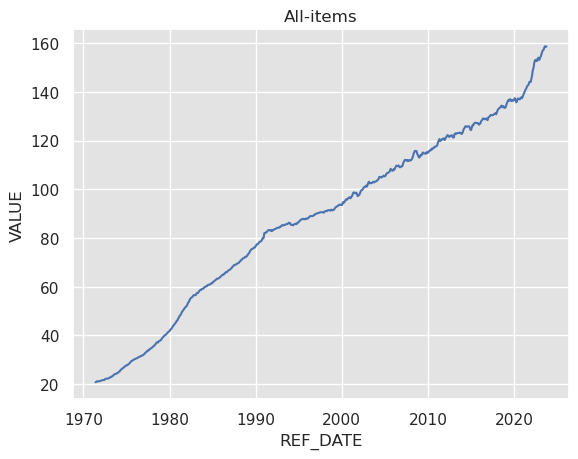

In [19]:
sns.lineplot(data=ref_cpi.series)
plt.title("All-items")
plt.show()

### Deviation Ref CPI Calculation - BoC Reporting
>INFO: Claculation precise for base (=issue) dates > 2007; Reason 1) is most probably a changing in the base year from 1992 to 2002. Instead of re-evaluating all historical reference CPIs the BoC introduced conversion factors that carry a five-digit precision and therfore bring additional deviation.
>
For some of the ILBs there's reported Reference CPIs:

In [20]:
def show_base_cpi_deviation(bond):
    print(bond, " ",df_info.loc[bond,"NAME"])
    
    base = df_info.loc[bond,"ISSUE DATE"]
    boc_cpi = df_info.loc[bond,"REF CPI BASE"]
    
    print("Issue Date: ",base)
    print("Calculation: ", ref_cpi.ref_cpi(base)) 
    print("Bank of Canada: ", boc_cpi)

out_05 = widgets.interactive_output(show_base_cpi_deviation,{"bond":ilb_dropdown})

display(ilb_dropdown, out_05)

Dropdown(description='ILB', options=(('CANADA 1991 4 1/4% 01/12/21 INDXLK.', '597973'), ('CANADA 1993 PKG. STR…

Output()

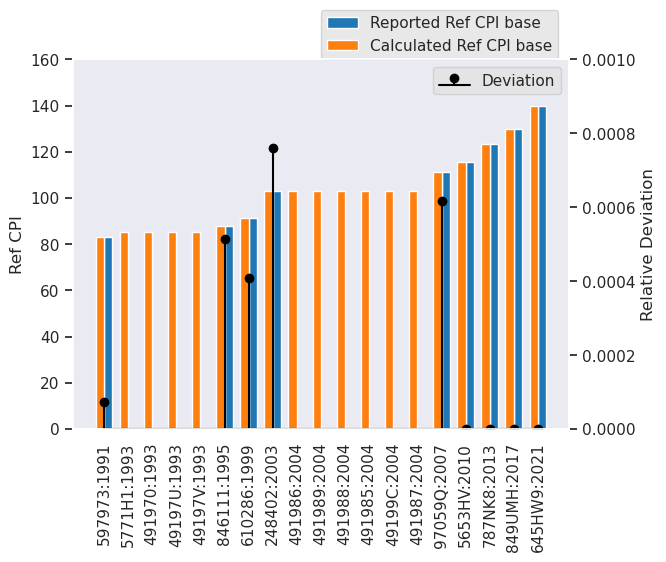

In [21]:
df_info_ilbs = df_info.loc[ilbs,:]
df_info_ilbs.sort_index(key= lambda x: df_info_ilbs.loc[x,"ISSUE DATE"],inplace=True)

issue_dates = [df_info.loc[bond,"ISSUE DATE"] for bond in df_info_ilbs.index]
cpi_reals = [df_info.loc[bond,"REF CPI BASE"] for bond in df_info_ilbs.index]
cpi_calcs = [ref_cpi.ref_cpi(issue_date) for issue_date in issue_dates]
diff = [abs(a-b)/a for a,b in zip(cpi_reals,cpi_calcs)]
labels = [n+":"+d.strftime("%Y") for n,d in zip(df_info_ilbs.index,issue_dates)]

with sns.axes_style("dark"):
    fig,ax = plt.subplots()
    ax1 = plt.twinx()

ax.bar(x=range(len(df_info_ilbs.index)),height=cpi_reals,align="edge",width=0.35,color="tab:blue",label="Reported Ref CPI base")
ax.bar(x=range(len(df_info_ilbs.index)),height=cpi_calcs,align="edge",width=-0.35,color="tab:orange",label="Calculated Ref CPI base")

ax1.stem(range(len(df_info_ilbs.index)),diff,linefmt="black",markerfmt="o",basefmt="black",label="Deviation")

ax.set_ylim(0,160)
ax1.set_ylim(0,0.001)

ax.set_xticks(range(len(df_info_ilbs.index)),labels=labels,rotation=90)
ax.set_ylabel("Ref CPI")
ax1.set_ylabel("Relative Deviation")

ax.legend(loc=(0.5,1))
ax1.legend()
plt.show()

# Bond Evaluation

In [22]:
df_info.loc["597973",:]

ISIN CODE                                   CA135087UL60
NAME                 CANADA 1991 4 1/4% 01/12/21 INDXLK.
COUPON                                            7.3104
AMOUNT ISSUED                                  5175000.0
COUPON DATES                                 01/06,01/12
INDEX LINKED COUP                                   4.25
COUPONS PER YEAR                                       2
1ST COUPON VALUE                                   2.026
OTHER YIELD                                       -3.635
RED. YIELD                                           NaN
CURRENCY                                              C$
ISSUE DATE                           1991-12-10 00:00:00
MATURITY YEAR                                       2021
START YEAR                                          1991
ACTIVE                                              Dead
REDEMPTION DATE                      2021-12-01 00:00:00
REF CPI BASE                                    83.07713
TYPE                           

### Evaluation as Nominal Bond - Example
Checked back and verified with [Vindeep](https://vindeep.com/Corporate/BondYTMCalculator.aspx)

#### Coupon Bond
String Representation:

In [23]:
bnd_id = "597973"
name = df_info.loc[bnd_id,"NAME"]
issue_date = df_info.loc[bnd_id,"ISSUE DATE"]
redem_date = df_info.loc[bnd_id,"REDEMPTION DATE"]
coupon = df_info.loc[bnd_id,"INDEX LINKED COUP"]

bond = Bond(issue_date,redem_date,coupon,coupon_freq=["AS-DEC","AS-JUN"],name=name,id=bnd_id)
bond

597973 | CANADA 1991 4 1/4% 01/12/21 INDXLK. | 4.25
10/12/91 - 01/12/21

### Cashflow
Evaluating the cashflows for a given date including accrued interest (dirty price):

In [24]:
eval_date = pd.Timestamp("2018-07-23")
price = df_prices.loc[eval_date,bnd_id]
cfs = bond.cashflows(eval_date,price,dirty=True,daycount="act/365")
print(f"Observed price on {eval_date.strftime('%d/%m/%Y')}: {price}")
cfs

Observed price on 23/07/2018: 112.882


2018-07-23   -113.487479
2018-12-01      2.125000
2019-06-01      2.125000
2019-12-01      2.125000
2020-06-01      2.125000
2020-12-01      2.125000
2021-06-01      2.125000
2021-12-01    102.125000
dtype: float64

The calculation of the **YTM** for the given evaluation date is based on the cashflow structure above and leads to:

In [25]:
bond.ytm(eval_date,price)

0.0038451369790610222

Inspecting the date differences utilized in the calculation of the internal rate of return (yield):

,cf,dd
2018-07-23,-113.487479,0
2018-12-01,2.125000,131
2019-06-01,2.125000,313
2019-12-01,2.125000,496
2020-06-01,2.125000,679
2020-12-01,2.125000,862
2021-06-01,2.125000,1044
2021-12-01,102.125000,1227


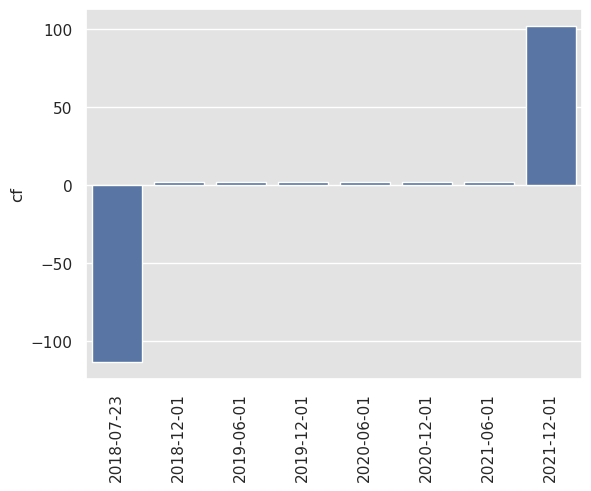

In [26]:
df = pd.DataFrame(cfs,columns=["cf"])
df["dd"] = (cfs.index-eval_date).days
fig,ax = plt.subplots()
sns.barplot(df,x=df.index,y="cf",ax=ax)
plt.xticks(rotation=90)
plt.xlabel("")
display(df)
plt.show()

#### Zero Bond
The evaluation of zero bonds is possible with a bond object having:
`Coupon = 0` <br>
`Coupon Dates = []` <br>

In [27]:
bnd_id = "597973"
name = df_info.loc[bnd_id,"NAME"]
issue_date = df_info.loc[bnd_id,"ISSUE DATE"]
redem_date = df_info.loc[bnd_id,"REDEMPTION DATE"]
prices = df_prices[bnd_id]
coupon = 0

zero_bond = Bond(issue_date, redem_date, coupon, id = bnd_id,name=name)
zero_bond

597973 | CANADA 1991 4 1/4% 01/12/21 INDXLK. | 0
10/12/91 - 01/12/21

In [28]:
zero_bond.cashflows(eval_date,93)

2018-07-23    -93.0
2021-12-01    100.0
dtype: float64

In [29]:
zero_bond.ytm(eval_date, 93)

0.02182256261202775

### Evaluation of ILBs - Example
Entweder ref_cpi_base übergeben, ansonsten wird es berechnet für das
issue_date.
#### Cashflows

In [30]:
ilb = ILB(issue_date,redem_date,4.25,coupon_freq=["AS-DEC","AS-JUN"],cpi_base = 83.07713,name=name)
cfs_ilb = ilb.cashflows(eval_date,price)
print(ilb)
cfs_ilb

None | CANADA 1991 4 1/4% 01/12/21 INDXLK. | 4.25
10/12/91 - 01/12/21


2018-07-23   -113.854029
2018-12-01      3.419869
2019-06-01      3.463346
2019-12-01      3.483810
2020-06-01      3.494053
2020-12-01      3.501724
2021-06-01      3.570786
2021-12-01    175.664191
dtype: float64

### Index Ratios & Ref CPI Base
Compare: BoC (`en_inratio21-12.pdf`): 4.25% 1 Dec. 2021 Ref CPI Base: 83.07713 | IR für 1 Dec. 2021: 1.72009 <br>
Compare [BoC Index Ratios](https://www.bankofcanada.ca/markets/government-securities-auctions/calls-for-tenders-and-results/real-return-bonds/real-return-bonds-index-ratio/) <br>
**Frage: Auch den negativen CF (Marktpreis) mit einem IR skalieren?**
#### Scaling the Cash Flows of an ILB

In [31]:
ilb.index_ratios

2018-07-23    1.00000
2018-12-01    1.60935
2019-06-01    1.62981
2019-12-01    1.63944
2020-06-01    1.64426
2020-12-01    1.64787
2021-06-01    1.68037
2021-12-01    1.72009
dtype: float64

In [32]:
#ilb.ytm(eval_date,price)
ilb.__dict__ #TODO: add parameter "accrued interest"

{'id': None,
 'name': 'CANADA 1991 4 1/4% 01/12/21 INDXLK.',
 'issue_date': Timestamp('1991-12-10 00:00:00'),
 'redem_date': Timestamp('2021-12-01 00:00:00'),
 'prices': None,
 'coupon': 4.25,
 'freq': 2,
 'coupon_freq': ['AS-DEC', 'AS-JUN'],
 'accrued_interest': 0.9720290269490103,
 'coupon_dates': DatetimeIndex(['1992-06-01', '1992-12-01', '1993-06-01', '1993-12-01',
                '1994-06-01', '1994-12-01', '1995-06-01', '1995-12-01',
                '1996-06-01', '1996-12-01', '1997-06-01', '1997-12-01',
                '1998-06-01', '1998-12-01', '1999-06-01', '1999-12-01',
                '2000-06-01', '2000-12-01', '2001-06-01', '2001-12-01',
                '2002-06-01', '2002-12-01', '2003-06-01', '2003-12-01',
                '2004-06-01', '2004-12-01', '2005-06-01', '2005-12-01',
                '2006-06-01', '2006-12-01', '2007-06-01', '2007-12-01',
                '2008-06-01', '2008-12-01', '2009-06-01', '2009-12-01',
                '2010-06-01', '2010-12-01', '2011-06

# Yield Curves
## Yield-to-Maturity
**Daily yield to maturity for a given bond** (!= Zero Curve) <br>
**Für Nominal Bonds**: Cashflows lassen sich für jedes beliebige Redemption Datum berechnen: <br>
**Für ILBs gilt**: Die historrischen YTMs lassen sich nur bis zu einem Redemption Datum berechnen, für welche auch eine Ref CPI, abgeleitet aus historischen CPIs existiert. Sonst kann der Index-Ratio nicht berechnet werden mit dem die Cashflows skaliert werden.

### Initializing an ILB with IR-scaled cashflows

In [33]:
eval_date = pd.Timestamp("2009-08-05")

bnd_id = "597973"
name = df_info.loc[bnd_id,"NAME"]
issue_date = df_info.loc[bnd_id,"ISSUE DATE"]
redem_date = df_info.loc[bnd_id,"REDEMPTION DATE"]
coupon = df_info.loc[bnd_id,"INDEX LINKED COUP"]

ilb_expl = ILB(issue_date,redem_date,coupon,coupon_freq=["AS-JUN","AS-DEC"],name=name,id=bnd_id)
ilb_expl

597973 | CANADA 1991 4 1/4% 01/12/21 INDXLK. | 4.25
10/12/91 - 01/12/21

In [34]:
#Setting prices after initilaizing
#accessing historical prices with the Bond.prices attribute

ilb_expl.prices = df_prices[ilb_expl.id]
price = ilb_expl.prices.loc[eval_date]
ilb_expl.cashflows(eval_date,price)

2009-08-05   -129.545488
2009-12-01      2.934094
2010-06-01      2.957108
2010-12-01      2.990364
2011-06-01      3.054326
2011-12-01      3.085011
2012-06-01      3.113146
2012-12-01      3.120818
2013-06-01      3.143852
2013-12-01      3.154074
2014-06-01      3.192451
2014-12-01      3.218036
2015-06-01      3.230829
2015-12-01      3.251292
2016-06-01      3.271756
2016-12-01      3.294770
2017-06-01      3.322905
2017-12-01      3.345940
2018-06-01      3.399660
2018-12-01      3.420124
2019-06-01      3.463601
2019-12-01      3.484065
2020-06-01      3.494307
2020-12-01      3.501979
2021-06-01      3.571041
2021-12-01    175.677468
dtype: float64

In [35]:
ilb_expl.ytm(eval_date,price)

0.06930407553358851

### Example: Spline Fitting
**Cashflows**: Claculated with `Initial` as **dirty** price and `Coupon` as **nominal** coupons. <-> YTM for ILBs are calculated like teh YTM for a nominal bond <br>
**Info:** ytm very sensitive to missing(?) data/ constant prices: e.g. `CPN STRIP 01/12/19`

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import Pipeline
import pickle

with open("export/ytm_ilb_as_nominal_dataframes.pickle","rb") as f:
#with open("export/ytm_ilb_as_ir_scaled_dataframes.pickle","rb") as f:
    data = pickle.load(f)

In [37]:

#sort labels for the dropdown by type and issue date
sorted_keys = sorted(data.keys(),key=lambda l: (0 if df_info.loc[l,"TYPE"]=="ILB" else 1,list(df_info.index).index(l)))
ytm_dropdown = widgets.Dropdown(description = "Bond",options = [(df_info.loc[lbl,"NAME"],lbl) for lbl in sorted_keys])
ytm_dropdown.value = "46269V"

log_checkbox = widgets.Checkbox(description = "log",value=False)

spline_checkbox = widgets.Checkbox(description= "Spline",value=True)

def plot_yield_curve(bond,log=False,spline=True):
    yield_curve = data[bond].dropna()
    df_sorted = yield_curve.sort_values(by="TTM")

    fig,axs = plt.subplots(nrows=2,height_ratios=(3,2),sharex=True)
    sns.lineplot(yield_curve,x="TTM",y="YTM",linewidth=.75,ax=axs[0],color="tab:grey",label="YTM")

    if spline:
        X,y = df_sorted[["TTM"]], df_sorted["YTM"]
    
        model = Pipeline([
            ('poly', SplineTransformer(n_knots=7,degree=3)), #Spline with N=9
            ('linear', LinearRegression())
        ])
        model.fit(X,y)
    
        X_test = pd.DataFrame(data=np.linspace(X.min(),X.max(),100),columns=["TTM"])
        y_pred = model.predict(X_test)

        sns.lineplot(x=X_test["TTM"],y=y_pred,ax=axs[0],linewidth=1,linestyle="--",color="tab:red",label="Spline")
    
    if log:
        axs[0].set_yscale("log")
        
    sns.lineplot(data=yield_curve,x="TTM",y="P",ax=axs[1],label="Price",linewidth=0.75)
    axs[0].set_title(bond)
    plt.tight_layout()
    plt.show()

out_06 = widgets.interactive_output(plot_yield_curve,{"bond":ytm_dropdown,"log":log_checkbox,"spline":spline_checkbox})
display(ytm_dropdown,log_checkbox,spline_checkbox,out_06)

Dropdown(description='Bond', index=21, options=(('CANADA 1991 4 1/4% 01/12/21 INDXLK.', '597973'), ('CANADA 19…

Checkbox(value=False, description='log')

Checkbox(value=True, description='Spline')

Output()

**Question:** The YTMs seem reasonable but seem to diverge for some bonds as they come closer to maturity e.g. `CANADA 2020 1/4%`
### Detail Investigation
TODO: Span Selector

597973 | CANADA 1991 4 1/4% 01/12/21 INDXLK. | 4.25
10/12/91 - 01/12/21


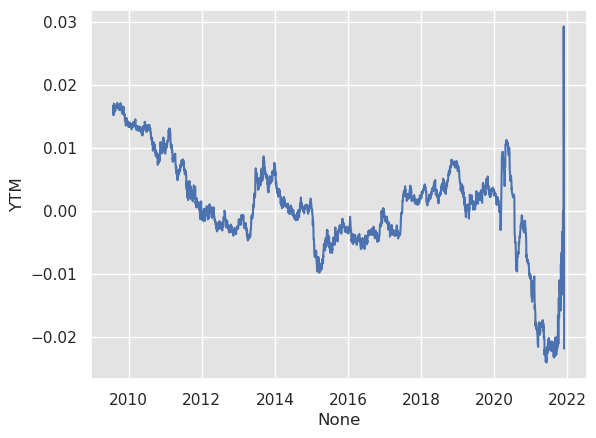

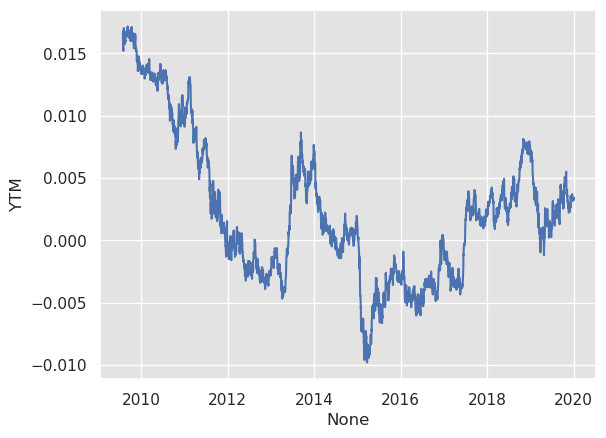

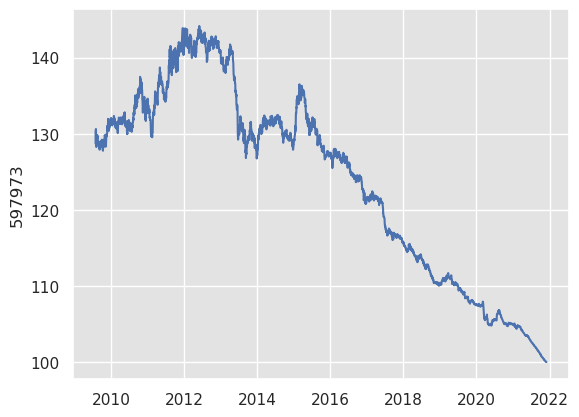

In [38]:
print(ilb_expl)
yield_curve = data[ilb_expl.id]

sns.lineplot(yield_curve,x=yield_curve.index,y="YTM")
#plt.yscale("log")
plt.show()

yc_clean = yield_curve.loc[:"2020-01-01",:]

sns.lineplot(yc_clean,x=yc_clean.index,y="YTM")
plt.show()

sns.lineplot(ilb_expl.prices)
plt.show()

## Current-Yield Curves

# Break Even Inflation
$$
y^{N}-y^{R} = E[\pi] + \phi^{IRP} + \phi^{LIQ}
$$
## Choosing ILB - Nominal Bond Pairs
ILB: YTM based on cash flow with `INDEX LINKED COUP` <br>
Nominal Bond: YTM based on cash flow with `COUPON` <br>
<br>
**First approach**: Substituting the expected inflation term $E[\phi]$ in the equation above with the actually realized inflation `CPI yearly percent change` results in a first guess for the inherent inflation risk premium $\phi^{IRP}$

In [69]:
noms_dropdown = widgets.Dropdown(description="Nominals",options=list(map(lambda t:t[::-1],list(df_info.loc[noms,["NAME"]].itertuples(name=None)))))
noms_dropdown = widgets.Dropdown(options=[(lbl,val) for lbl,val in zip(df_info.loc[noms,"NAME"].values,noms)],description="Nominal")
df_cpi_pct = pd.read_csv("data/total_cpi_pct.csv",index_col="date",parse_dates=True)
#cpi_obj = RefCPI()
#df_cpi_pct = cpi_obj.series.pct_change(periods=12)

def compare_yields(ilb,nom):
    fig, axs = plt.subplots(nrows=2,sharex=True,height_ratios=(3,2))
    df_ilb, df_nom = data[ilb], data[nom]
    sns.lineplot(df_ilb,x=df_ilb.index,y="YTM",ax=axs[0],label="ILB",color="blue",linewidth=0.5)
    sns.lineplot(df_nom,x=df_nom.index,y="YTM",ax=axs[0],label="Nominal Bond",color="red",linewidth=0.5)

    bei = df_nom["YTM"] - df_ilb["YTM"]
    bei.dropna(inplace=True)
    sns.lineplot(bei,color="green",ax=axs[0],linewidth=0.5,label="BEI")
    axs[0].fill_between(bei.index.values, bei.values,color="tab:green",alpha=0.5,linewidth=0,label="BEI")
    
    #Vergleich mit CPI monthly percentage
    sns.lineplot(bei,ax=axs[1],color="tab:green",linewidth=0.5,label="BEI")

    min_dt, max_dt = min(bei.index) + pd.DateOffset(day=1), max(bei.index) + pd.DateOffset(day=1)
    cpi = df_cpi_pct.loc[min_dt:max_dt,"STATIC_ATABLE_V41690973"]/100
    sns.lineplot(cpi,color="black",linewidth=0.5,label="CPI% p.a.")
    irp = bei.resample("MS").first() - cpi
    axs[1].fill_between(irp.index.values,irp.values,color="tab:blue",alpha=0.5,linewidth=0.5,label="IRP*")

    plt.legend()
    axs[1].set_xlabel("")
    axs[1].set_ylabel("")
    plt.tight_layout()
    plt.show()
    print(ilb, nom)

widgets.interact_manual(compare_yields,ilb=ilb_dropdown, nom=noms_dropdown);

interactive(children=(Dropdown(description='ILB', index=5, options=(('CANADA 1991 4 1/4% 01/12/21 INDXLK.', '5…

In [ ]:
pairs = [("846111", "846564"),("610286", "610451"),("248402", "46269V"),("97059Q", "2180M7"),("5653HV", "2180M7"),
         ("5653HV", "6487P3"),("787NK8", "794D5D"),("849UMH", "860K02"),("645HW9", "650WAD")]


### Break-Even Inflation Grid
All Pairs plotted against each other:

In [ ]:
#TODO

## Inflation Risk Premium
### Average Break-Even Rate vs. Inflation Forecast
See [Bank of Canada, Inflation Expectations](https://www.bankofcanada.ca/rates/indicators/capacity-and-inflation-pressures/expectations/)

In [143]:


all_bei = []
for ilb, nom in pairs:
    df_ilb, df_nom = data[ilb], data[nom]
    bei = df_nom["YTM"] - df_ilb["YTM"]
    avg_duration = (df_info.loc[ilb,"DURATION"] + df_info.loc[nom,"DURATION"])/2
    bei.rename(get_class(avg_duration),inplace=True)
    bei.dropna(inplace=True)
    all_bei.append({"ILB":ilb,"NOM":nom,"BEI":bei})

df_bei = pd.concat([d["BEI"] for d in all_bei],axis=1)

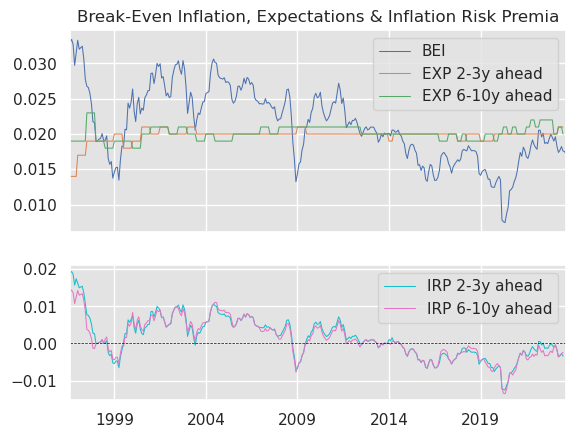

In [285]:
from datasets import inflation_expectations

fig, axs = plt.subplots(nrows=2,sharex = True,height_ratios=(3,2))

df_results = pd.DataFrame()
df_results["BEI"] = df_bei.mean(axis=1).resample("MS").mean()
df_results = df_results.join(inflation_expectations)
for ei in inflation_expectations.columns:
    df_results[f"IRP {ei}"] = df_results["BEI"] - df_results[ei]
df_results.rename(columns={"2-3y ahead":"EXP 2-3y ahead","6-10y ahead":"EXP 6-10y ahead"},inplace=True)

df_results[["BEI","EXP 2-3y ahead","EXP 6-10y ahead"]].plot(ax=axs[0],linewidth=0.75)
df_results[["IRP 2-3y ahead","IRP 6-10y ahead"]].plot(ax=axs[1],linewidth=0.75,color=["tab:cyan","tab:pink"])
axs[1].axhline(y=0,linestyle="--",linewidth=0.5,color="black")

#plt.tight_layout()
axs[0].set_title("Break-Even Inflation, Expectations & Inflation Risk Premia")
plt.savefig("export/plot_00.svg")
plt.show()

## Reported Yield-Spreads
**Expectations implicit in real/nominal bond spread**
Yield spread between conventional (selected long-term government of Canada benchmark bond yields) and benchmark real return bonds. as reported by the [Bank of Canada, Expectations](https://www.bankofcanada.ca/rates/indicators/capacity-and-inflation-pressures/expectations/)

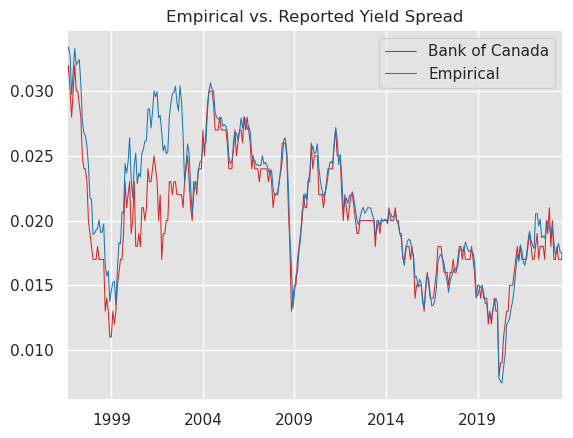

In [283]:
from datasets import yield_spread

df_results["reported BEI"] = yield_spread
df_results["reported BEI"].plot(label="Bank of Canada",linewidth=0.75,color="tab:red")
df_results["BEI"].plot(label="Empirical",linewidth=0.75,color="tab:blue")
plt.legend()
plt.title("Empirical vs. Reported Yield Spread")
plt.savefig("export/plot_01.svg")
plt.show()

# Expected Inflation
Opt. 1-3, see [Grishchenko & Huang, 2012](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2027101) <br>

## Option 1: Average Historical Inflation Rate
The next (=expected) value is given by the average inflation rate of the last T years. <br>
- `window`: the window length in month to calculate the historic average: $T$ <br>
- `shift`: the shift into the future; e.g. a shift of 12 means that the prediction is made for a date 12 month into the future: $\tau$

$$
T \in (1, 3, 5, 7, 10) \dots [T] = \text{years}
$$
$$
\tau \in (57, 81, 117) \dots [\tau] = \text{months}
$$

In [41]:
from sklearn.metrics import mean_squared_error

cpi_obj = RefCPI()

style = {'description_width': 'initial'}
window_len_slider = widgets.IntSlider(value=12,min=1,max=120,description="Window T (month)",continuous_update=False,style=style)
shift_slider = widgets.IntSlider(value=57,min=1,max=117,description="Shift (FH) 𝜏 (month)",continuous_update=False,style=style)

def plot_rolling_avg_cpi(window,shift,periods):
    fig, ax = plt.subplots()
    orig = cpi_obj.series.pct_change(periods=periods)
    sns.lineplot(orig,label="CPI",ax=ax)
    
    #the next (=expected) cpi is given by the mean of the n historic values
    shift = cpi_obj.series.pct_change(periods=periods).rolling(window).mean().shift(shift,freq="infer")
    sns.lineplot(shift,label="Predicted CPI",ax=ax)
    
    res = pd.concat([orig,shift],axis=1,keys = ["orig","shift"])
    mse = mean_squared_error(res.dropna()["orig"],res.dropna()["shift"])
    print(f"RMSE: {m.sqrt(mse)}")
    
    plt.xlabel("")
    plt.ylabel("CPI")
    plt.legend()
    plt.show()
    
    #print(res.tail())
    #return m.sqrt(mse)
    

widgets.interactive(plot_rolling_avg_cpi,window=window_len_slider,shift=shift_slider,periods=widgets.fixed(12))

interactive(children=(IntSlider(value=12, continuous_update=False, description='Window T (month)', max=120, mi…

$$
RMSE = \sqrt{\frac{1}{n} \sum{(CPI_t - \hat{I}_t)^2}}
$$

In [42]:
#Tabular RMSEs for all combinations of T and tau

cpi_pa = cpi_obj.series.pct_change(12).dropna()

def get_se(date:pd.Timestamp,T:int,tau:int)->float:
    """
    Returns the squared error of the predicted CPI and observed CPI.
    The predicted value is given by the mean of the last T years.
    """
    start = date - pd.DateOffset(years=T)
    pred_date = date + pd.DateOffset(months=tau)
    y_pred = cpi_pa.loc[start:date].mean()
    y_test = cpi_pa.loc[pred_date]
    
    return (y_pred-y_test)**2

def rmse()->pd.DataFrame:
    rmse_results = []
    for T in tqdm([1,3,5,7,10]):
        for tau in tqdm([57,81,117],leave=False):
            ses = []
            for date in cpi_pa.index:
                try:
                    ses.append(get_se(date,T,tau))
                except KeyError as e:
                    pass
            rmse_results.append({"T":T,"tau":tau,"RMSE":m.sqrt(np.mean(ses))})
    return pd.DataFrame(rmse_results)

df_rmse = rmse()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [43]:
df_rmse.groupby(by="tau")[["RMSE"]].mean()
df_rmse

,T,tau,RMSE
0,1,57,0.028107
1,1,81,0.029450
2,1,117,0.035205
3,3,57,0.026937
4,3,81,0.030401
5,3,117,0.035571
6,5,57,0.027404
7,5,81,0.031049
8,5,117,0.036423
9,7,57,0.028145


## Option 2: VAR - Vector Auto Regression
![k-dinemsional VAR(p)](assets/VAR_p_k_dim.png)

see [Ang & Piazzesi, 2003](https://www.sciencedirect.com/science/article/pii/S0304393203000321); [Grishchenko & Huang, 2007](https://www.fdic.gov/analysis/cfr/2008/april/grishchenko-huang.pdf) <br>
VAR(1) with 10y previous data for each date t and different forecast horizons: 57, 81, 117
$$
T = 10 \dots [T] = \text{years}
$$
$$
\tau \in (57, 81, 117) \dots [\tau] = \text{months}
$$
- CPI: year-to-year rates <-> CPI
- CPI core: year-to-year rates
- PPI - Production Price Index: year-to-year rates <-> IPPI
- PCOM - spot market commodity prices: year-to-year rates <-> BCPI

and
- HELP - Help Wanted Advertising in the Newspapers Index (discontinued in 2003): log growth rate
- UE - Unemployment rate <-> UER
- EMPLOY - civil employment: log growth rate of civil employment <-> EMP
- IP - Industrial Production Index: log growth rate <-> IP

All growth rates (including inflation) are 
measured as the difference in logs of the index at time t and - 12; t in month (Ang & Piazzesi, 2003)

### Time Series for VAR

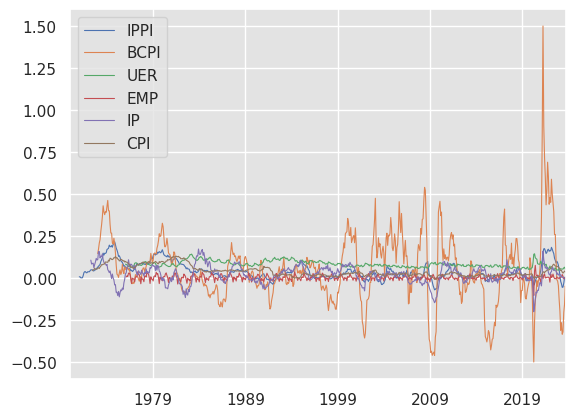

In [44]:
ippi = pd.read_csv("data/ippi_long.csv",index_col="REF_DATE",date_format="%Y-%m",usecols=["REF_DATE","VALUE"])
ippi = ippi.pct_change(periods=12)
ippi.index.namme="date"
ippi.columns = ["IPPI"]

bcpi = pd.read_csv("data/bcpi.csv",index_col="date",date_format="%Y-%m-%d",usecols=["date","M.BCPI"])
bcpi.rename(columns={"M.BCPI": "BCPI"},inplace=True)
bcpi = bcpi.pct_change(periods=12)

uer = pd.read_csv("data/ue_long.csv",index_col="REF_DATE",usecols=["REF_DATE","VALUE"],date_format="%Y-%m")
uer.index.name = "date"
uer.columns=["UER"]
uer = uer/100

emp = pd.read_csv("data/emp.csv",index_col="REF_DATE",date_format="%Y-%m")
emp.index.name="date"
emp = emp[["VALUE"]]
emp.rename(columns={"VALUE":"EMP"},inplace=True)
emp = emp.pct_change()

ip = pd.read_csv("data/ip_long.csv",usecols=["TIME","Value"],index_col="TIME",date_format="%Y-%m")
ip.index.name="date"
ip.columns=["IP"]
ip = ip.pct_change(12)

cpi = pd.DataFrame(data=RefCPI().series)
cpi.rename(columns={"VALUE":"CPI"},inplace=True)
cpi.index.name = "date"
cpi = cpi.pct_change(periods=12)

df_ts = pd.concat([ippi,bcpi,uer,emp,ip,cpi],axis=1,sort=True)
df_ts.plot(linewidth=0.8)

plt.show()

### Correlation Matrix

In [45]:
df_ts.corr()

,IPPI,BCPI,UER,EMP,IP,CPI
IPPI,1.000000,0.565924,-0.070607,0.048270,0.234266,0.705019
BCPI,0.565924,1.000000,-0.210950,0.073609,0.353434,0.221872
UER,-0.070607,-0.210950,1.000000,-0.006379,-0.017339,0.057431
EMP,0.048270,0.073609,-0.006379,1.000000,0.078787,0.019905
IP,0.234266,0.353434,-0.017339,0.078787,1.000000,-0.048607
CPI,0.705019,0.221872,0.057431,0.019905,-0.048607,1.000000


### Testing for Stationarity
VAR needs time series to be stationary:

In [46]:
from sktime.param_est.stationarity import StationarityADF

results = {}
for s in df_ts.columns:
    adf = StationarityADF(regression="c")
    adf.fit(df_ts[s].dropna())  
    results[s] = adf.get_fitted_params()["stationary"]
results

{'IPPI': True,
 'BCPI': True,
 'UER': True,
 'EMP': True,
 'IP': True,
 'CPI': False}

In [47]:
#make all data stationary by building differences
adf = StationarityADF(regression="c")
transform = df_ts[["CPI"]].diff()
adf.fit(transform.dropna())
adf.get_fitted_params()

{'pvalue': 1.221904287921365e-07,
 'stationary': True,
 'test_statistic': -6.059550735031482,
 'used_lag': 15}

In [48]:
df_ts["CPI_diff"] = df_ts["CPI"].diff()

df_ts.dropna()

,IPPI,BCPI,UER,EMP,IP,CPI,CPI_diff
1976-02-01,0.059055,0.047611,0.080,0.005727,0.029745,0.093190,-0.004636
1976-03-01,0.059055,0.061538,0.076,0.011143,0.064038,0.092857,-0.000333
1976-04-01,0.054688,0.062529,0.075,0.007912,0.067419,0.088652,-0.004205
1976-05-01,0.050193,0.047057,0.068,0.027718,0.107328,0.084211,-0.004442
1976-06-01,0.054054,0.050788,0.066,0.027083,0.076645,0.079861,-0.004349
...,...,...,...,...,...,...,...
2023-04-01,-0.035249,-0.266799,0.052,0.004731,0.006242,0.044059,0.001077
2023-05-01,-0.056518,-0.335864,0.052,0.019611,0.006053,0.033575,-0.010484
2023-06-01,-0.055471,-0.321610,0.052,0.009069,-0.001072,0.028123,-0.005452
2023-07-01,-0.031931,-0.205907,0.059,-0.005873,-0.001514,0.032658,0.004535


### VAR(1) - Predicting the future
The formula for a two-dimensional VAR(1) process is given by:
![2-dimensional VAR(1)](assets/VAR_1_2_dim.png)
#### Full-length training data
Test: Using all available (historical) data to train the model for predicting the next (future) 36 months:

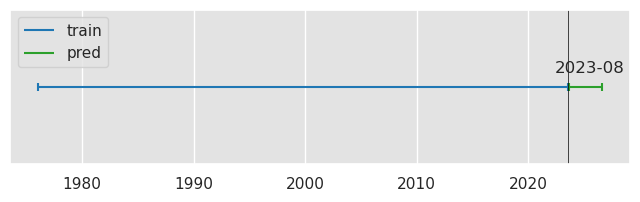

In [49]:
from sktime.forecasting.var import VAR

vars = ["IPPI","BCPI","UER","EMP","IP","CPI"]

#Setting the forecast horizon: forecast for every month in the next 3 years
fh = np.arange(1,37) #[57, 81, 117] (Grishchenko & Huang, 2007)

df_ts.index = pd.PeriodIndex(df_ts.index,freq="M")
y_train = df_ts.loc[:,vars].dropna()

forecaster = VAR(maxlags=1) #VAR(1) process (Grishchenko & Huang, 2007)
forecaster.fit(y_train, fh=fh)

y_pred = forecaster.predict()

fig, ax = plt.subplots(figsize=(8,2))
xmin_train,xmax_train = y_train.index[0].to_timestamp(), y_train.index[-1].to_timestamp()
xmin_pred,xmax_pred = y_pred.index[0].to_timestamp(), y_pred.index[-1].to_timestamp()
plt.hlines(y=1,xmin=xmin_train,xmax=xmax_train,color="tab:blue",label="train")
plt.hlines(y=1,xmin=xmin_pred,xmax=xmax_pred,color="tab:green",label="pred")
ax.scatter([xmin_train,xmax_train],[1,1],marker="|",color="tab:blue")
ax.scatter([xmin_pred,xmax_pred],[1,1],marker="|",color="tab:green")
ax.axvline(x=xmax_train,color="black",linewidth=0.5)
ax.annotate(xmax_train.strftime("%Y-%m"),(xmax_train,1),xytext=(-10,10),textcoords="offset points")
plt.yticks([])
plt.legend()
plt.show()

In [50]:
all_ts_checkbox = widgets.Checkbox(value=False,description="Show all training series")

def plot_VAR_detail(show_all:bool):
    fig, ax =  plt.subplots()

    y_train["CPI"].plot(ax=ax,label="train")
    y_pred["CPI"].plot(ax=ax,label="pred",color="tab:green")
    if show_all:
        y_train.drop(columns="CPI").plot(ax=ax,color="grey",linewidth=0.5)


    ax.set_xlim(left=y_train.index[-120],right=y_pred.index[-1])
    ax.axvline(x=xmax_train,color="black",linewidth=0.5)
    plt.legend()
    plt.ylabel("CPI")
    plt.title("VAR(1) - all training data - detail view")
    plt.show()

widgets.interactive(plot_VAR_detail,show_all=all_ts_checkbox)

interactive(children=(Checkbox(value=False, description='Show all training series'), Output()), _dom_classes=(…

#### Variable training window size and forecast horizon
E.g. VAR(1) with 10y training data and forecast horizons 57, 81, 117 months (see Grishchenko & Huang, 2012):
$$
T = 10 \dots [T] = \text{years}
$$
$$
\tau \in (57, 81, 117) \dots [\tau] = \text{months}
$$

Evaluation date: 2013-01
RSE 57-th point:  0.0045225204733901625
RMSE forecast horizon:  0.005683041590776839


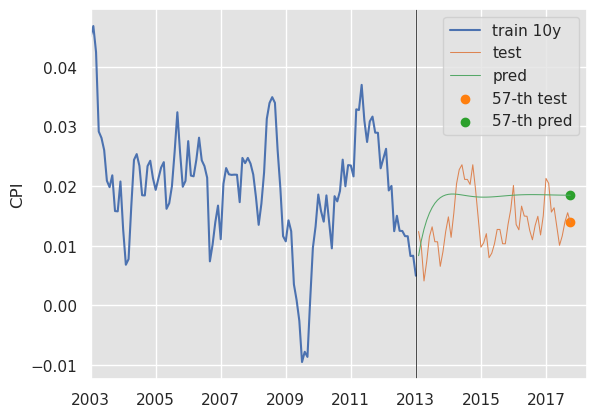

In [51]:
evaluation_date = "2013-01"

#forecast horizon \tau
fh = np.arange(1,58) #every month for 57 month into the future
test_point = fh[-1] #the 57-th month

#training window size
years = 10
ws = pd.DateOffset(years=10) #training on the past T=10y of data prior to evaluation_date

start_train = pd.Timestamp(evaluation_date) - ws
end_train = pd.Timestamp(evaluation_date)
start_test = end_train + pd.DateOffset(months=1)
end_test = start_test + pd.DateOffset(months=fh[-2])

y_train = df_ts.loc[start_train:end_train,vars].dropna()
y_test = df_ts.loc[start_test:end_test,vars]

forecaster = VAR(maxlags=1) #VAR(1) process (Grishchenko & Huang, 2007)
results = forecaster.fit(y_train,fh=fh)
y_pred = results.predict()

fig, ax = plt.subplots()

y_train["CPI"].plot(label=f"train {years}y",ax=ax)
y_test["CPI"].plot(label="test",ax=ax,linewidth=0.75)
y_pred["CPI"].plot(label="pred",ax=ax,linewidth=0.75)

plt.scatter(end_test,y_test.loc[end_test,"CPI"],label=f"{test_point}-th test",color="tab:orange")
plt.scatter(end_test,y_pred.loc[end_test,"CPI"],label=f"{test_point}-th pred",color="tab:green")

plt.legend()

ax.set_xlim(left=start_train,right=end_test+pd.DateOffset(months=6))
ax.set_ylabel("CPI")
ax.set_xlabel("")
ax.axvline(x=end_train,color="black",linewidth=0.5)

print("Evaluation date:", evaluation_date)
print("RSE 57-th point: ",m.sqrt((y_pred.loc[end_test,"CPI"]-y_test.loc[end_test,"CPI"])**2))
print("RMSE forecast horizon: ", m.sqrt(mean_squared_error(y_test["CPI"],y_pred["CPI"])))

plt.show()

In [52]:
results._fitted_forecaster.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Dec, 2023
Time:                     11:00:45
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -52.8074
Nobs:                     120.000    HQIC:                  -53.3868
Log likelihood:           2247.34    FPE:                4.39224e-24
AIC:                     -53.7830    Det(Omega_mle):     3.12573e-24
--------------------------------------------------------------------
Results for equation IPPI
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.013741         0.010085            1.363           0.173
L1.IPPI         0.966848         0.043774           22.088           0.000
L1.BCPI         0.037853         0.006934            5.459           0.000
L1.UER    

In [53]:
#TODO: Tabular results for average RMSE for every point in time with forecast horizon [57, 81, 117]
df_predictions = df_ts.dropna()

def get_predict(date:pd.Timestamp,tau:int=57,T=10)->pd.DataFrame:
    """
    Return the VAR(1) prediction at a given date for an forecast horizon of tau months and T years aof training
    data before date.
    Example:
    date = pd.Timestamp("2022-01-03")
    tau = 57 (default)
    T = 10 (default)
    Returns the prediction for 2026-10 (date + 57 months into the future)
    """
    start_train = date - pd.DateOffset(years=T)
    end_train = date
    y_train = df_ts.loc[start_train:end_train,vars]

    forecaster = VAR(maxlags=1) #VAR(1)
    forecaster.fit(y_train,fh=tau)

    df = forecaster.predict().add_suffix("_pred")
    df["tau"] = tau
    return df

get_predict(pd.Timestamp("2022-01-03"))

,IPPI_pred,BCPI_pred,UER_pred,EMP_pred,IP_pred,CPI_pred,tau
2026-10,0.05393,0.107038,0.071278,0.000664,0.005975,0.024735,57


Evaluating the VAR(1) prediction for every point in time results in the expected inflation (CPI) curve: 

In [54]:
#earliest possible date for predicting the future
def get_limit_dates(tau:int, T:int=10):
    first_date = df_ts.dropna().index.min().to_timestamp()
    last_date = df_ts.dropna().index.max().to_timestamp()
    earliest_date = first_date + pd.DateOffset(years=T)
    latest_date = last_date - pd.DateOffset(months=tau)
    return earliest_date, latest_date

ed, ld = get_limit_dates(57)
print("Earliest possible date: ", ed) #so that the date at the start of the training period 10y before is covered
print("Latest necessery date: ",ld) #so that every prediction can be compared to real values

Earliest possible date:  1986-02-01 00:00:00
Latest necessery date:  2018-11-01 00:00:00


In [55]:
dfs = []
dates = pd.date_range(start="1986-02-01",end="2018-11-01",freq="m")
for date in tqdm(dates):
    dfs.append(get_predict(date,tau=57))

  0%|          | 0/393 [00:00<?, ?it/s]

In [56]:
df_pred = pd.concat(dfs)
expected_inflation = df_pred.loc[:,["CPI_pred"]]
expected_inflation.index.name= "date"
expected_inflation

,CPI_pred
date,
1990-11,0.021066
1990-12,0.010044
1991-01,0.006071
1991-02,0.012418
1991-03,0.010070
...,...
2023-03,0.015256
2023-04,0.014944
2023-05,0.015231


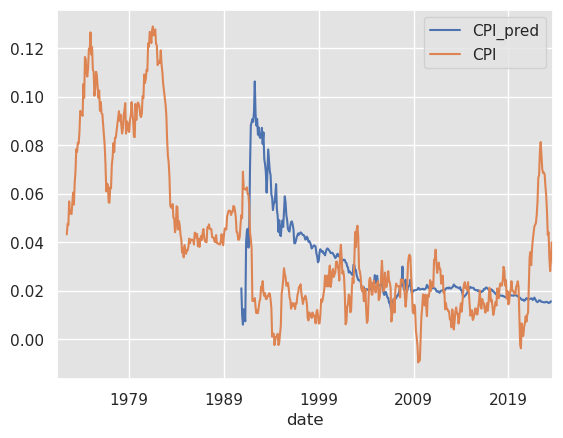

In [57]:
fig,ax=plt.subplots()
xmin = expected_inflation.index.min()
xmax = expected_inflation.index.max()
expected_inflation.plot(ax=ax,label="expected inflation")
cpi.plot(ax=ax,label="real inflation")
#plt.xlim(left=xmin,right=xmax)
plt.show()

In [58]:
#TODO: Tabular results RSMEs for VAR(1), 10y with tau = 57, 81, 117
y_train.columns

Index(['IPPI', 'BCPI', 'UER', 'EMP', 'IP', 'CPI'], dtype='object')

#### Bonus: Finding the Optimal Hyperparameters
Variation of lag-order p with training on all available historical data

In [59]:
from statsmodels.tsa.api import VAR as sm_VAR

vars = ["IPPI","BCPI","UER","EMP","IP","CPI"]

model = sm_VAR(df_ts.loc[:,vars].dropna())
max_estimable = (model.n_totobs - model.neqs - 1) // (1 + model.neqs)

lag_slider = widgets.IntSlider(value=35,max=max_estimable,min=1, description="Lag (p) month",continuous_update=False)
tau_slider = widgets.IntSlider(value=70,max=100,min=1,description="forecast horizon (tau) month",continuous_update=False)

def tune_model(lag,tau):
    results = model.fit(lag)
    print("AIC:", results.aic)
    fc = results.forecast(results.endog[-results.k_ar:],tau)

    endog_df = pd.DataFrame(model.endog, columns=vars)
    fc_df = pd.DataFrame(fc, columns=vars)
    fc_df.index=fc_df.index+endog_df.index.max()

    lag_start, lag_end = endog_df.index.values[-lag], endog_df.index.max()
    
    fig,ax = plt.subplots()
    ax.axvspan(lag_start,lag_end,alpha=0.5,color="grey",linestyle=None,label="lag")
    endog_df["CPI"].plot(ax=ax,label="CPI")
    #endog_df.drop(columns="CPI").plot(ax=ax,color="grey",linewidth=0.5)
    fc_df["CPI"].plot(ax=ax,label="CPI pred")
    ax.axhline(y=0.03,color="black",linewidth=0.5,label="Target rate")
    ax.axhline(y=0.01,color="black",linewidth=0.5)
    ax.axhline(y=0.02,color="black",linewidth=0.5,linestyle="--")
    
    plt.xlim(endog_df.index.max()-100,fc_df.index.max()+10)
    plt.legend()
    plt.show()

widgets.interactive(tune_model,lag=lag_slider,tau = tau_slider)

interactive(children=(IntSlider(value=35, continuous_update=False, description='Lag (p) month', max=80, min=1)…

In [60]:
aics = []
lags = range(1,max_estimable)
for lag in tqdm(lags):
    results = model.fit(lag)
    aics.append(results.aic)

  0%|          | 0/79 [00:00<?, ?it/s]

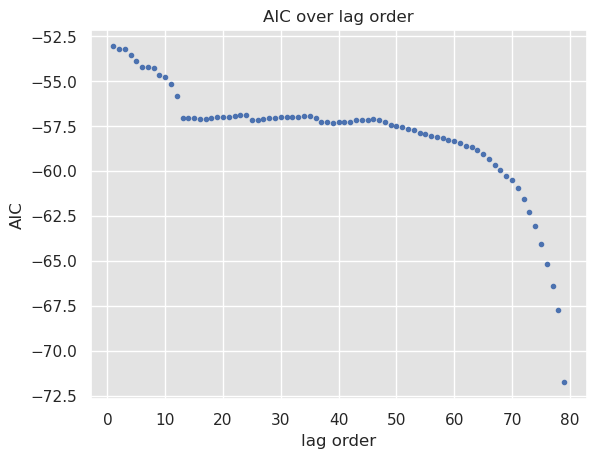

In [61]:
plt.scatter(lags,aics,marker=".")
plt.ylabel("AIC")
plt.xlabel("lag order")
plt.title("AIC over lag order")
plt.show()

### Conclusion
- In general, one wants to minimize [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) when choosing the optimal lag order p for a VAR(p) model - nevertheless, in our example this would lead us to choosing the max. possible model size which results in unrealistic future scenarios
- Adding other time series that represent (fiscal) political measures such as prime rate, target inflation rate etc. could potentially improve forecasting performance. [Target rate Canada](https://www.bankofcanada.ca/rates/indicators/key-variables/inflation-control-target/)


## Option 3: SPF - Professional Inflation Expectation Forecasts
Inflation Expectations as reported by the [Bank of Canada, Inflation Expectations](https://www.bankofcanada.ca/rates/indicators/capacity-and-inflation-pressures/expectations/). <br>
**Question**: Is the break-even inflation at t minus the inflation expectation at t the t-length inflation risk premium?
$$
BEI_t - E[\pi]_{t,n}  = IRP_{t,n} \
$$
$$
t \dots \text{at time t}
$$
$$
n \dots \text{expectation for n years ahead}
$$

In [62]:
from datasets import inflation_expectations, yield_spread

<Axes: xlabel='date'>

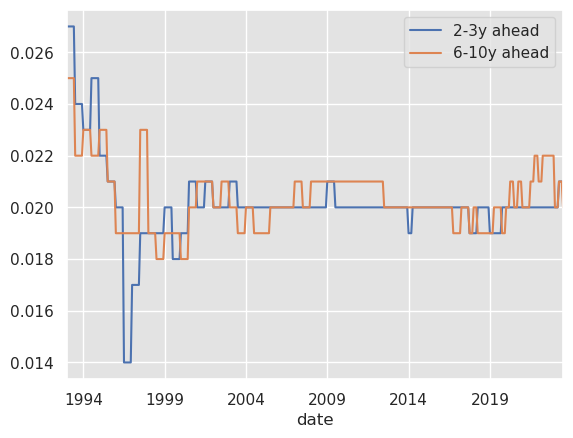

In [63]:
inflation_expectations.plot()

<Axes: xlabel='date'>

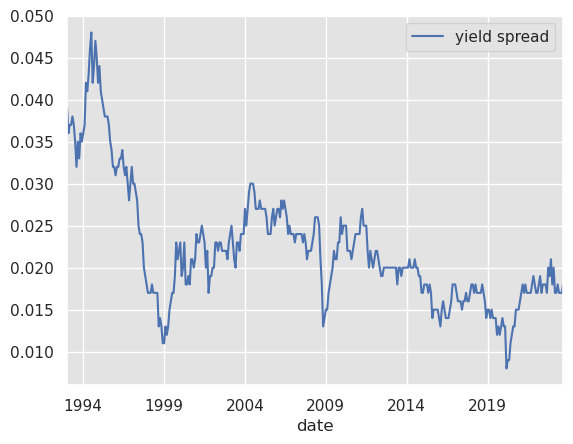

In [64]:
yield_spread.plot()

## Option 4: Term Structure Models
## Option 5: AR/ARIMA - Single Time Series Auto Regression

# Bank of Canada API

In [65]:
import requests
import json
import pandas as pd
base_url = "https://www.bankofcanada.ca/valet/"
#r = requests.get(base_url+"observations/INDEX_RATIO_2021/csv")

In [66]:
r = requests.get("https://www.bankofcanada.ca/valet/observations/INDINF_EXPECTTWOTHREE_Q")

In [67]:
r.text

'{\n    "terms": {\n        "url": "https://www.bankofcanada.ca/terms/"\n    },\n    "seriesDetail": {\n        "INDINF_EXPECTTWOTHREE_Q": {\n            "label": "INDINF_EXPECTTWOTHREE_Q",\n            "description": "CPI inflation: Consensus Forecasts - 2-3 years",\n            "dimension": {\n                "key": "d",\n                "name": "Date"\n            }\n        }\n    },\n    "observations": [\n        {\n            "d": "1993-01-01",\n            "INDINF_EXPECTTWOTHREE_Q": {\n                "v": "2.5"\n            }\n        },\n        {\n            "d": "1993-04-01",\n            "INDINF_EXPECTTWOTHREE_Q": {\n                "v": "2.5"\n            }\n        },\n        {\n            "d": "1993-07-01",\n            "INDINF_EXPECTTWOTHREE_Q": {\n                "v": "2.2"\n            }\n        },\n        {\n            "d": "1993-10-01",\n            "INDINF_EXPECTTWOTHREE_Q": {\n                "v": "2.2"\n            }\n        },\n        {\n            "d